# Deep Transfer Learning for Land Cover Classification

- Objective: develop land cover classifier trained on satellite images.
- Method: transfer learning with Wide Residual Networks (`50` CNNs) on the Land Cover (EuroSAT) dataset.
- Results: `95%` accuracy with `0.03` loss on test data.
- Optimizations: boost efficiency with gradient clipping, adaptive learning rates, and data augmentation.
- Dataset: `27,000` labeled images from Sentinel-2 satellite, data obtained via copernicus.eu (EU project).
- Applications: maps correction, urban planning, natural catastrophe prediction, precision agriculture.
- Resourses: ["Deep Transfer Learning for Land Use and Land Cover Classification: A Comparative Study"](https://www.mdpi.com/1424-8220/21/23/8083)

[Here](./Deep%20Transfer%20Learning%20for%20Land%20Cover%20Classification.pdf) you can find a short project presentaion. 

In [1]:
# Automatic reloading of Python modules when they are modified,
# ensuring that the most up-to-date code is always used without needing to restart the kernel
%load_ext autoreload
%autoreload 2


Let's start by importing necessary libraries and tools.

In [2]:
# Analysis related imports
import pandas as pd

# Import related to visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports related to ML
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.utils.data import DataLoader


Now we import our dataset with RGB images of land. 

In [3]:
# Upload EuroSAT_RGB dataset
!wget -nc -O EuroSAT_RGB.zip "https://www.dropbox.com/scl/fi/sqvqylptp50149ia5nmri/EuroSAT_RGB.zip?rlkey=ils4jst3ozm11d896veksl9us&dl=1"
!rm -r EuroSAT_RGB
!unzip -q EuroSAT_RGB.zip


File ‘EuroSAT_RGB.zip’ already there; not retrieving.


## Preprocessing

Now let's set up GPU CPU switch and preprocess the data to optimise model's work. 

In [ ]:
# Set up the device to GPU if available, otherwise using the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose(
    [
        # Resize images to 224x224 pixels
        transforms.Resize((224, 224)),
        # Apply random horizontal and vertical flips
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # Apply random rotations within the range of -45 to 45 degrees
        transforms.RandomRotation(degrees=(-45, 45)),
        # Apply random Gaussian blur with a 5x5 kernel with a 50% probability
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
        # Convert images to PyTorch tensors
        transforms.ToTensor(),
        # Normalize pixel values using specified mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
# Load the EuroSAT_RGB dataset
dataset = ImageFolder(root=r"./EuroSAT_RGB", transform=transform)

true_labels = []
predicted_labels = []

# Extract class labels (folder names) from your dataset
class_labels = dataset.classes


Let's see how preprocessed data looks like. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


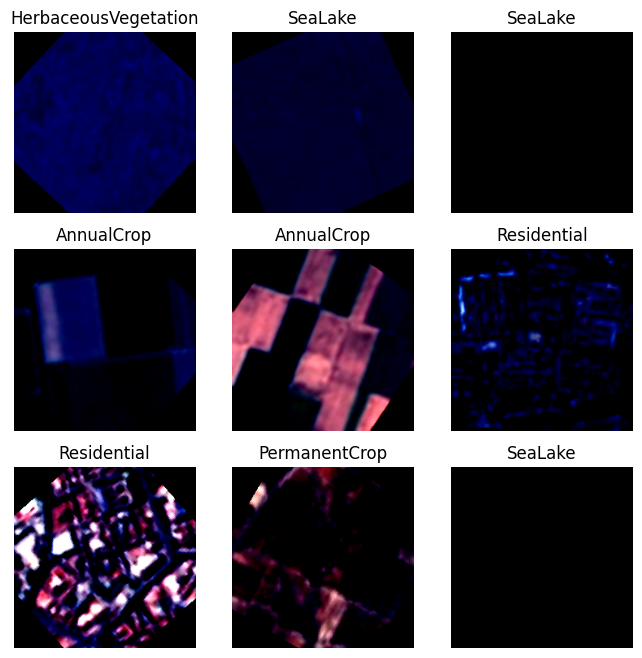

In [5]:
labels_map = {i: cls for i, cls in enumerate(dataset.classes)}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()


Looks like images been rotated and tonality has changed to a small scale.

## Build Baseline Model without Pretrained Weights

In [6]:
# Create a DataLoader for training and validation
batch_size = 16

generator1 = torch.Generator().manual_seed(42)
[train, validation] = torch.utils.data.random_split(
    dataset, [0.75, 0.25], generator=generator1
)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(
    validation, batch_size=batch_size, shuffle=True, pin_memory=True
)


In [7]:
# Import class defining pipeline  
from model import CustomWideResNet50

In [8]:
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


def train_one_model(model, train_loader, validation_loader, epochs=25):
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters())

    # Define the gradient clipping threshold
    gradient_clip_value = 1.0

    def train_one_epoch(epoch_index):
        running_loss = 0.0
        last_loss = 0.0
        total_correct = 0
        total_samples = 0
        i = 0

        # Here, we use enumerate(training_loader) instead of
        # iter(training_loader) so that we can track the batch
        # index and do some intra-epoch reporting
        for data in tqdm(train_loader, f"Epoch {epoch_index + 1}"):
            # Every data instance is an input + label pair
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)

            _, predicted = torch.max(outputs, 1)
            labels_np = labels.cpu().numpy()
            predicted_np = predicted.cpu().numpy()

            total_correct += accuracy_score(labels_np, predicted_np, normalize=False)
            total_samples += labels.size(0)

            # Adjust learning weights
            optimizer.step()

            running_loss += loss.item()

            if i % 10 == 9:
                last_loss = running_loss / 10  # loss per batch
                tb_x = epoch_index * len(train_loader) + i + 1
                writer.add_scalar("Loss/train", last_loss, tb_x)
                running_loss = 0.0

            i += 1

        return last_loss, total_correct / total_samples

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter("runs/fashion_trainer_{}".format(timestamp))
    best_vloss = 1_000_000.0

    metrics = []

    for epoch in range(epochs):
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, accuracy = train_one_epoch(epoch)

        running_vloss = 0.0
        total_correct = 0
        total_samples = 0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for vdata in tqdm(validation_loader, "test"):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)

                voutputs = model(vinputs)

                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss

                _, predicted = torch.max(voutputs, 1)

                vlabels_np = vlabels.cpu().numpy()
                predicted_np = predicted.cpu().numpy()

                total_correct += accuracy_score(
                    vlabels_np, predicted_np, normalize=False
                )
                total_samples += vlabels.size(0)

        avg_vloss = running_vloss / len(validation_loader)
        print(f"LOSS train {avg_loss} valid {avg_vloss}")

        vaccuracy = total_correct / total_samples
        print(
            f"Epoch {epoch + 1} Training Accuracy: {accuracy * 100:.2f}% Validation Accuracy: {vaccuracy * 100:.2f}%"
        )
        metrics.append(
            {
                "taccuracy": accuracy,
                "vaccuracy": vaccuracy,
                "tloss": avg_loss,
                "vloss": avg_vloss,
            }
        )

        writer.add_scalars(
            "Training vs. Validation Loss",
            {"Training": avg_loss, "Validation": avg_vloss},
            epoch + 1,
        )
        writer.add_scalars(
            "Training vs. Validation Accuracy",
            {"Training": accuracy, "Validation": vaccuracy},
            epoch + 1,
        )
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = "model_{}_{}".format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

    return metrics


In [ ]:
# Instantiate a CustomWideResNet50 baseline model for land cover classification
baseline_model = CustomWideResNet50(
    num_classes=len(class_labels), use_pretrained_weights=False
)
# Transfer model to GPU
baseline_model.to(device)


In [ ]:
# Save baseline metrics
baseline_metrics = train_one_model(baseline_model, train_loader, validation_loader)


In [ ]:
# Unload the model from memory
del baseline_model


## Build Baseline Model with Pretrained Weights

In [8]:
# Split the data on train, validaion and test
[train, validation, test] = torch.utils.data.random_split(
    dataset, [0.75, 0.20, 0.05], generator=generator1
)
train_loader = DataLoader(train, batch_size=64, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True, pin_memory=True)


In [11]:
transfer_learning_model = CustomWideResNet50(num_classes=len(class_labels))
transfer_learning_model.to(device)


CustomWideResNet50(
  (wide_resnet50_2): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

In [11]:
transfer_learning_metrics = train_one_model(
    transfer_learning_model, train_loader, validation_loader
)


Epoch 1:   0%|          | 0/317 [00:00<?, ?it/s]

test: 100%|██████████| 85/85 [00:30<00:00,  2.74it/s]


LOSS train 0.403361514210701 valid 0.31183624267578125
Epoch 1 Training Accuracy: 79.81% Validation Accuracy: 89.74%


test: 100%|██████████| 85/85 [00:31<00:00,  2.69it/s]


LOSS train 0.3274570420384407 valid 0.2505369484424591
Epoch 2 Training Accuracy: 88.25% Validation Accuracy: 91.33%


test: 100%|██████████| 85/85 [00:30<00:00,  2.76it/s]


LOSS train 0.28981391787528993 valid 0.2319185435771942
Epoch 3 Training Accuracy: 89.49% Validation Accuracy: 91.91%


test: 100%|██████████| 85/85 [00:30<00:00,  2.82it/s]


LOSS train 0.3115867331624031 valid 0.21470898389816284
Epoch 4 Training Accuracy: 90.56% Validation Accuracy: 92.61%


test: 100%|██████████| 85/85 [00:30<00:00,  2.83it/s]


LOSS train 0.294779634475708 valid 0.21719838678836823
Epoch 5 Training Accuracy: 90.60% Validation Accuracy: 92.50%


test: 100%|██████████| 85/85 [00:32<00:00,  2.62it/s]


LOSS train 0.33151634931564333 valid 0.1977677345275879
Epoch 6 Training Accuracy: 90.98% Validation Accuracy: 92.74%


test: 100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


LOSS train 0.21222893372178078 valid 0.19481971859931946
Epoch 7 Training Accuracy: 91.59% Validation Accuracy: 93.15%


test: 100%|██████████| 85/85 [00:31<00:00,  2.73it/s]


LOSS train 0.29667718037962915 valid 0.19417816400527954
Epoch 8 Training Accuracy: 91.40% Validation Accuracy: 93.24%


test: 100%|██████████| 85/85 [00:33<00:00,  2.54it/s]


LOSS train 0.23784684240818024 valid 0.18363909423351288
Epoch 9 Training Accuracy: 91.83% Validation Accuracy: 93.61%


test: 100%|██████████| 85/85 [00:31<00:00,  2.71it/s]


LOSS train 0.1900812305510044 valid 0.1736723780632019
Epoch 10 Training Accuracy: 91.86% Validation Accuracy: 93.63%


test: 100%|██████████| 85/85 [00:34<00:00,  2.49it/s]


LOSS train 0.2409959003329277 valid 0.17954644560813904
Epoch 11 Training Accuracy: 92.30% Validation Accuracy: 94.07%


test: 100%|██████████| 85/85 [00:31<00:00,  2.72it/s]


LOSS train 0.1525961883366108 valid 0.17324699461460114
Epoch 12 Training Accuracy: 91.92% Validation Accuracy: 94.26%


test: 100%|██████████| 85/85 [00:30<00:00,  2.76it/s]


LOSS train 0.24041048139333726 valid 0.1791655272245407
Epoch 13 Training Accuracy: 92.01% Validation Accuracy: 93.93%


test: 100%|██████████| 85/85 [00:31<00:00,  2.66it/s]


LOSS train 0.18033842444419862 valid 0.1962675303220749
Epoch 14 Training Accuracy: 92.12% Validation Accuracy: 93.50%


test: 100%|██████████| 85/85 [00:31<00:00,  2.74it/s]


LOSS train 0.2161460392177105 valid 0.17527921497821808
Epoch 15 Training Accuracy: 92.34% Validation Accuracy: 94.19%


test: 100%|██████████| 85/85 [00:30<00:00,  2.78it/s]


LOSS train 0.23242212682962418 valid 0.16965919733047485
Epoch 16 Training Accuracy: 92.23% Validation Accuracy: 94.09%


test: 100%|██████████| 85/85 [00:31<00:00,  2.68it/s]


LOSS train 0.21954430341720582 valid 0.17703835666179657
Epoch 17 Training Accuracy: 92.36% Validation Accuracy: 93.72%


test: 100%|██████████| 85/85 [00:31<00:00,  2.69it/s]


LOSS train 0.1963596113026142 valid 0.17534150183200836
Epoch 18 Training Accuracy: 92.61% Validation Accuracy: 94.28%


test: 100%|██████████| 85/85 [00:30<00:00,  2.79it/s]


LOSS train 0.22494289726018907 valid 0.1753767877817154
Epoch 19 Training Accuracy: 92.63% Validation Accuracy: 94.06%


test: 100%|██████████| 85/85 [00:30<00:00,  2.80it/s]


LOSS train 0.2097611114382744 valid 0.18024685978889465
Epoch 20 Training Accuracy: 92.49% Validation Accuracy: 94.07%


test: 100%|██████████| 85/85 [00:31<00:00,  2.71it/s]


LOSS train 0.2671947956085205 valid 0.19935975968837738
Epoch 21 Training Accuracy: 92.85% Validation Accuracy: 92.96%


test: 100%|██████████| 85/85 [00:31<00:00,  2.73it/s]


LOSS train 0.15123116075992585 valid 0.17165341973304749
Epoch 22 Training Accuracy: 92.66% Validation Accuracy: 94.26%


test: 100%|██████████| 85/85 [00:31<00:00,  2.66it/s]


LOSS train 0.2266005225479603 valid 0.16862790286540985
Epoch 23 Training Accuracy: 92.64% Validation Accuracy: 94.20%


test: 100%|██████████| 85/85 [00:39<00:00,  2.13it/s]


LOSS train 0.2524610385298729 valid 0.16603878140449524
Epoch 24 Training Accuracy: 92.71% Validation Accuracy: 94.20%


test: 100%|██████████| 85/85 [00:34<00:00,  2.45it/s]

LOSS train 0.24940589740872382 valid 0.1674910932779312
Epoch 25 Training Accuracy: 92.73% Validation Accuracy: 94.15%


Let's see what we have in metrics. 

In [12]:
transfer_learning_metrics


[{'taccuracy': 0.798074074074074,
  'vaccuracy': 0.8974074074074074,
  'tloss': 0.403361514210701,
  'vloss': tensor(0.3118, device='cuda:0')},
 {'taccuracy': 0.8824691358024691,
  'vaccuracy': 0.9133333333333333,
  'tloss': 0.3274570420384407,
  'vloss': tensor(0.2505, device='cuda:0')},
 {'taccuracy': 0.8949135802469136,
  'vaccuracy': 0.919074074074074,
  'tloss': 0.28981391787528993,
  'vloss': tensor(0.2319, device='cuda:0')},
 {'taccuracy': 0.9055802469135803,
  'vaccuracy': 0.9261111111111111,
  'tloss': 0.3115867331624031,
  'vloss': tensor(0.2147, device='cuda:0')},
 {'taccuracy': 0.9060246913580247,
  'vaccuracy': 0.925,
  'tloss': 0.294779634475708,
  'vloss': tensor(0.2172, device='cuda:0')},
 {'taccuracy': 0.9098271604938272,
  'vaccuracy': 0.9274074074074075,
  'tloss': 0.33151634931564333,
  'vloss': tensor(0.1978, device='cuda:0')},
 {'taccuracy': 0.9159012345679012,
  'vaccuracy': 0.9314814814814815,
  'tloss': 0.21222893372178078,
  'vloss': tensor(0.1948, device='cud

In [ ]:
# Unload the model from memory
del transfer_learning_model


## Test the Model with Pretrained Weights

In [ ]:
transfer_learning_model = CustomWideResNet50(num_classes=len(class_labels))
transfer_learning_model.load_state_dict(torch.load("./model_20231005_153312_23"))
transfer_learning_model.eval()
transfer_learning_model.to(device)

In [12]:
loss_fn = nn.NLLLoss()
total_correct = 0
total_samples = 0
running_vloss = 0
with torch.no_grad():
    for vdata in tqdm(test_loader, "test"):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)

        voutputs = transfer_learning_model(vinputs)

        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

        _, predicted = torch.max(voutputs, 1)

        vlabels_np = vlabels.cpu().numpy()
        predicted_np = predicted.cpu().numpy()

        total_correct += accuracy_score(
            vlabels_np, predicted_np, normalize=False
        )
        total_samples += vlabels.size(0)

avg_vloss = running_vloss / len(validation_loader)
print(f"Test LOSS {avg_vloss}")

vaccuracy = total_correct / total_samples
print(
    f"Test Accuracy: {vaccuracy * 100:.2f}%"
)


test:   0%|          | 0/22 [00:00<?, ?it/s]

test: 100%|██████████| 22/22 [00:19<00:00,  1.16it/s]

Test LOSS 0.032313086092472076
Test Accuracy: 95.04%


## Visualisation

Let's visualise training and validation changes in accuracy and loss for model with transfer learning applied and without. 

In [3]:
base_train_acc = pd.read_csv('./data/base_train_acc.csv')
base_train_loss = pd.read_csv('./data/base_train_loss.csv')
base_valid_acc = pd.read_csv('./data/base_valid_acc.csv')
base_valid_loss = pd.read_csv('./data/base_valid_loss.csv')

In [4]:
# Concatenate them along the columns (axis=1)
baseline_metrics = pd.concat([base_train_acc.set_index('Step'), 
                       base_valid_acc.set_index('Step'), 
                       base_train_loss.set_index('Step'), 
                       base_valid_loss.set_index('Step')], 
                      axis=1).reset_index()

baseline_metrics.head()

,Step,Wall time,Value,Wall time,Value,Wall time,Value,Wall time,Value
0,1,1.696457e+09,0.284741,1.696457e+09,0.364593,1.696457e+09,1.655939,1.696457e+09,1.485145
1,2,1.696458e+09,0.335012,1.696458e+09,0.469185,1.696458e+09,1.507055,1.696458e+09,1.270422
2,3,1.696458e+09,0.381926,1.696458e+09,0.457926,1.696458e+09,1.550987,1.696458e+09,1.272847
3,4,1.696458e+09,0.421383,1.696458e+09,0.510963,1.696458e+09,1.560246,1.696458e+09,1.195584
4,5,1.696459e+09,0.448741,1.696459e+09,0.586667,1.696459e+09,1.326313,1.696459e+09,1.057887


In [5]:
baseline_metrics.drop(columns='Wall time', inplace=True)

In [6]:
# Rename the columns for clarity (you can change these names as needed)
baseline_metrics.columns = ['Step', 'Train_Accuracy', 'Valid_Accuracy', 'Train_Loss', 'Valid_Loss']
baseline_metrics.tail()

,Step,Train_Accuracy,Valid_Accuracy,Train_Loss,Valid_Loss
19,20,0.814272,0.882222,0.642445,0.394429
20,21,0.826765,0.893333,0.524312,0.382361
21,22,0.828691,0.881630,0.534148,0.500373
22,23,0.840543,0.892148,0.610302,0.374623
23,24,0.842173,0.912593,0.489412,0.308550


In [7]:
from data.classifier_metrics import transfer_learning_metrics

In [8]:
classifier_metrics = pd.DataFrame(transfer_learning_metrics)
classifier_metrics['Step'] = range(1,26)
classifier_metrics.columns = ['Train_Accuracy', 'Valid_Accuracy', 'Train_Loss', 'Valid_Loss', 'Step']
classifier_metrics.tail()

,Train_Accuracy,Valid_Accuracy,Train_Loss,Valid_Loss,Step
20,0.926025,0.940556,0.253256,0.1734,21
21,0.928346,0.941852,0.187319,0.1788,22
22,0.927160,0.939074,0.241639,0.1739,23
23,0.925827,0.941667,0.208843,0.1670,24
24,0.928099,0.942407,0.218304,0.1719,25


In [9]:
# remove black frames
sns.despine(trim=True, right=True)

# Set style to 'darkgrid'
sns.set(style='darkgrid')


# Clear Matplotlib cache and save the plot in high resolution 
plt.rcParams.update({'figure.dpi': 300})
plt.savefig('output_figure.png')

<Figure size 640x480 with 0 Axes>

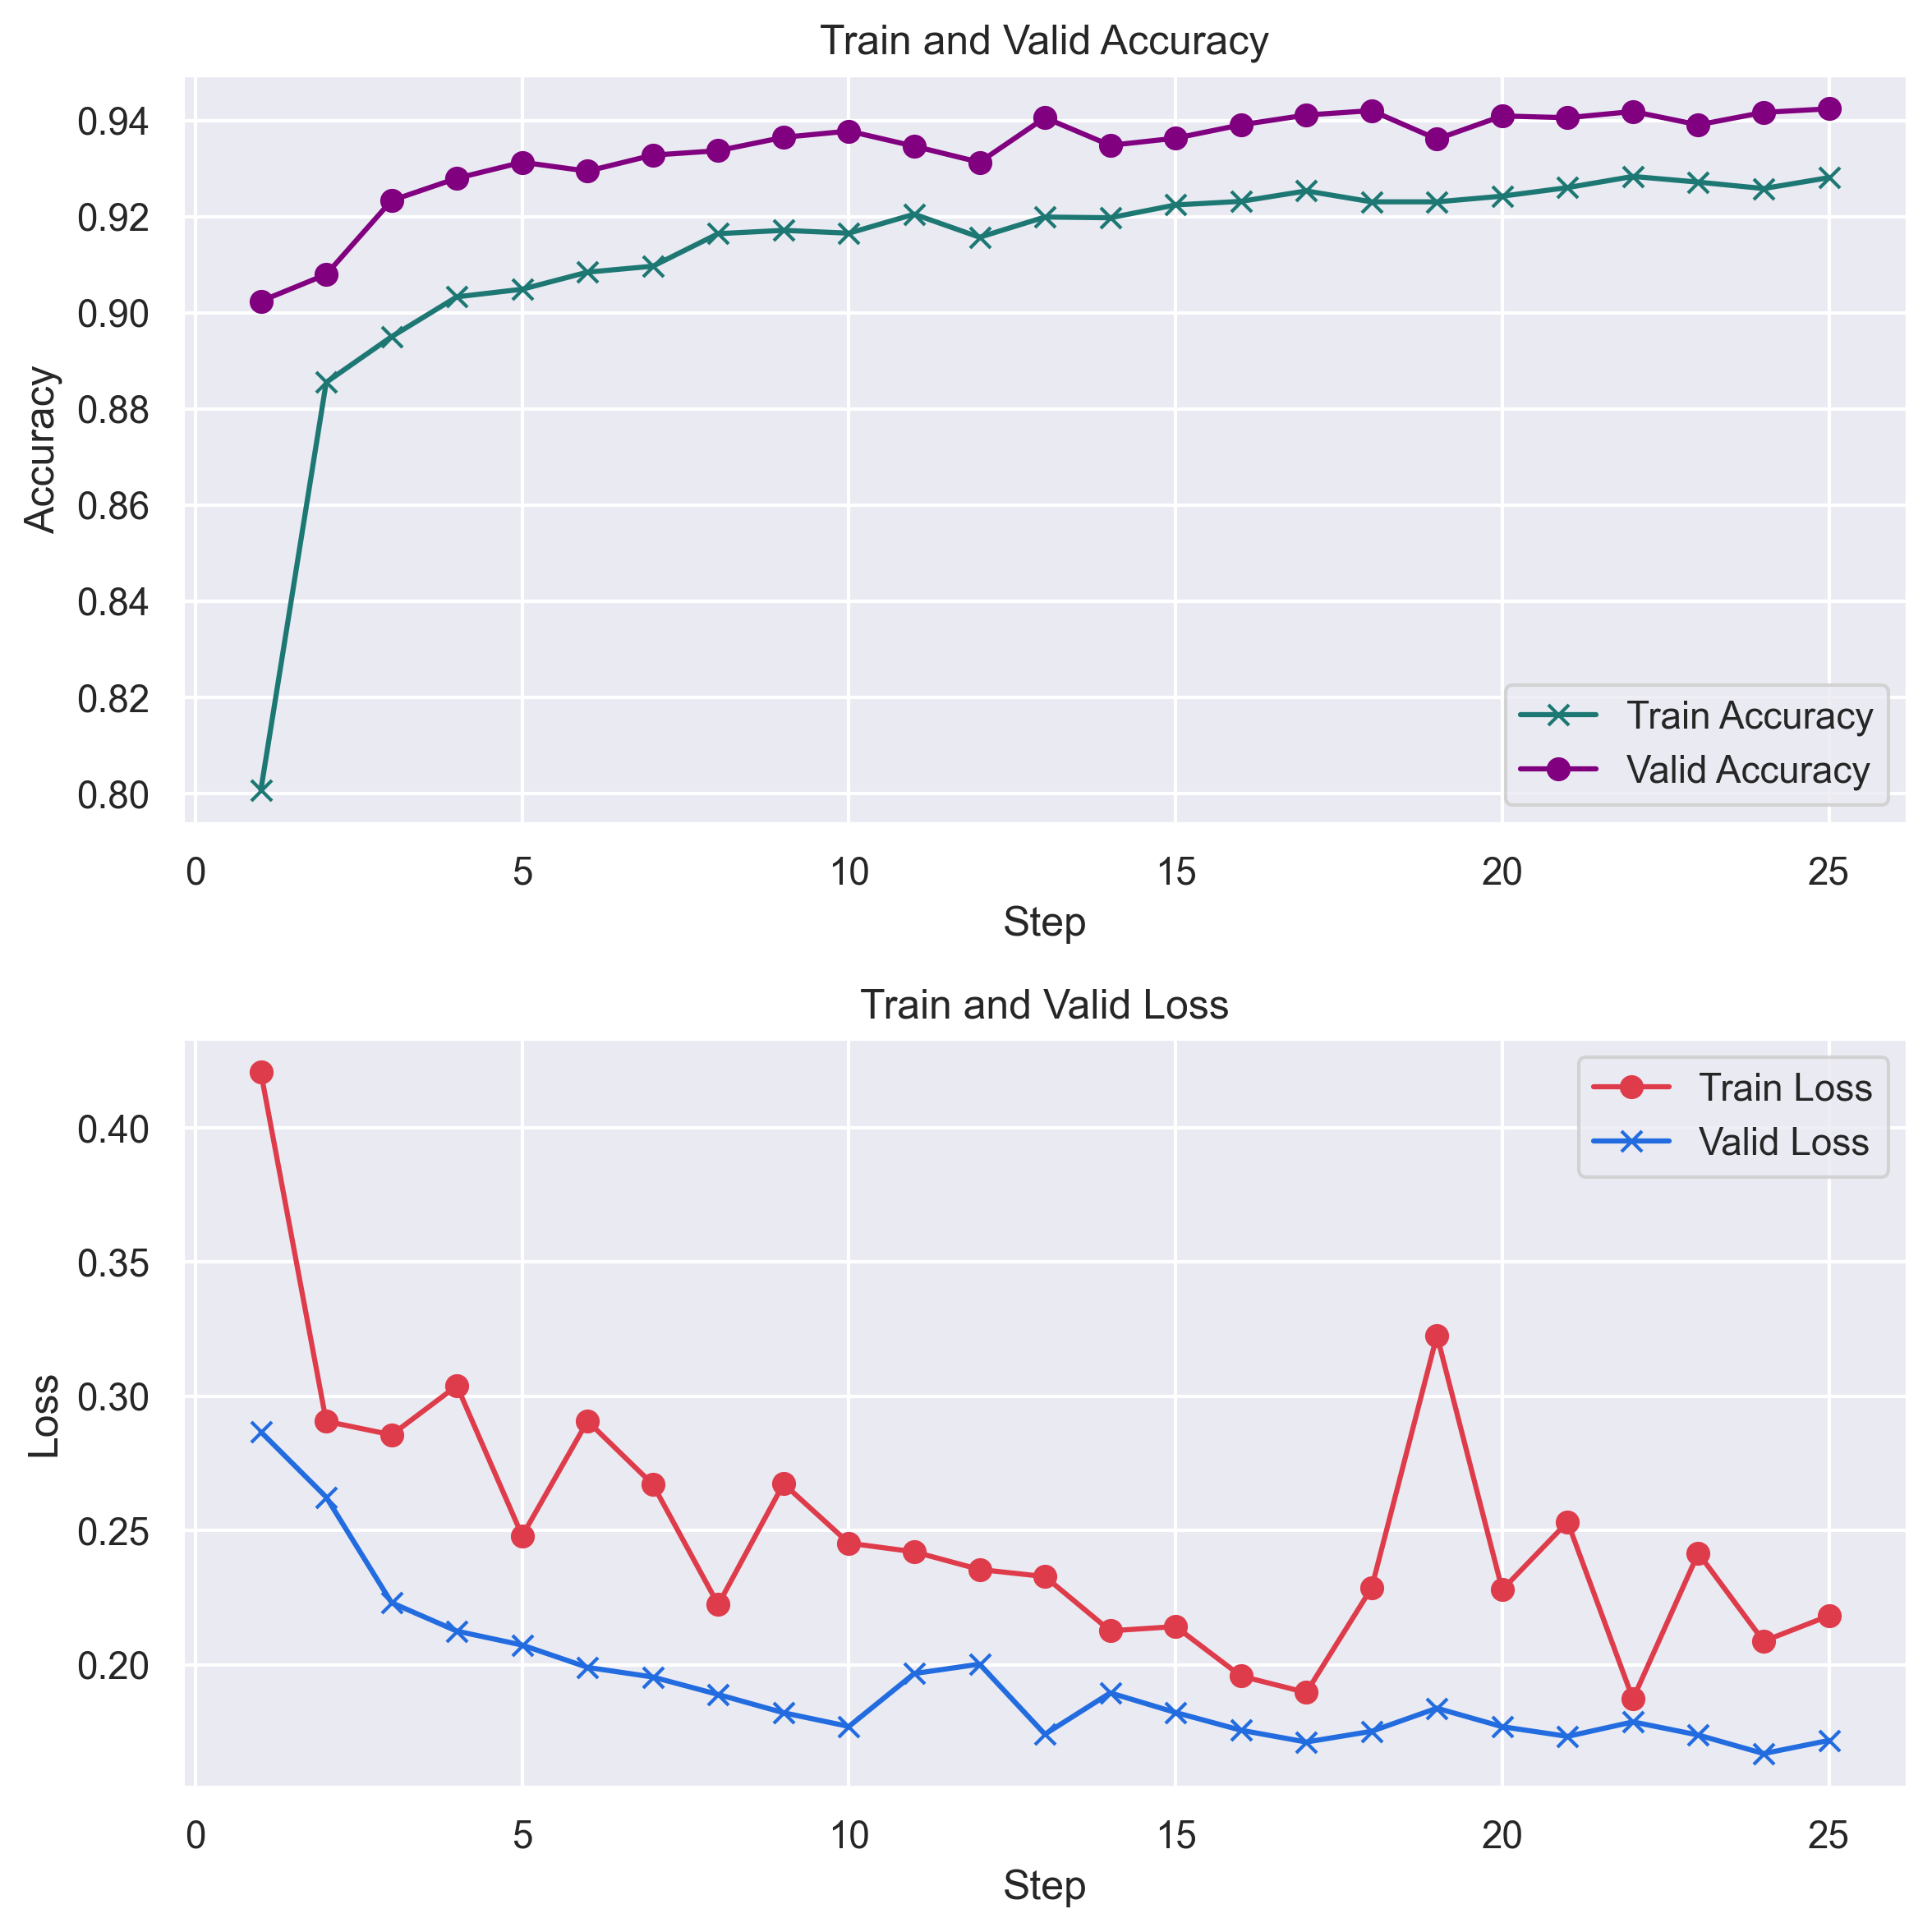

In [10]:
def plot_metrics(data, colors): 
    # Create a figure with two subplots (2 rows, 1 column)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    # Plot Train and Valid Accuracy on the first subplot
    axes[0].plot(data['Step'], data['Train_Accuracy'], label='Train Accuracy', marker='x', color=colors[0] )
    axes[0].plot(data['Step'], data['Valid_Accuracy'], label='Valid Accuracy', marker='o', color=colors[1])
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Train and Valid Accuracy')
    axes[0].legend()

    # Plot Train and Valid Loss on the second subplot
    axes[1].plot(data['Step'], data['Train_Loss'], label='Train Loss', marker='o', color=colors[2])
    axes[1].plot(data['Step'], data['Valid_Loss'], label='Valid Loss', marker='x', color=colors[3])
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Train and Valid Loss')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    return plt.show()

plot_metrics(classifier_metrics, colors=['#1D7874', '#800080', '#DE3C4B', '#226CE0'])

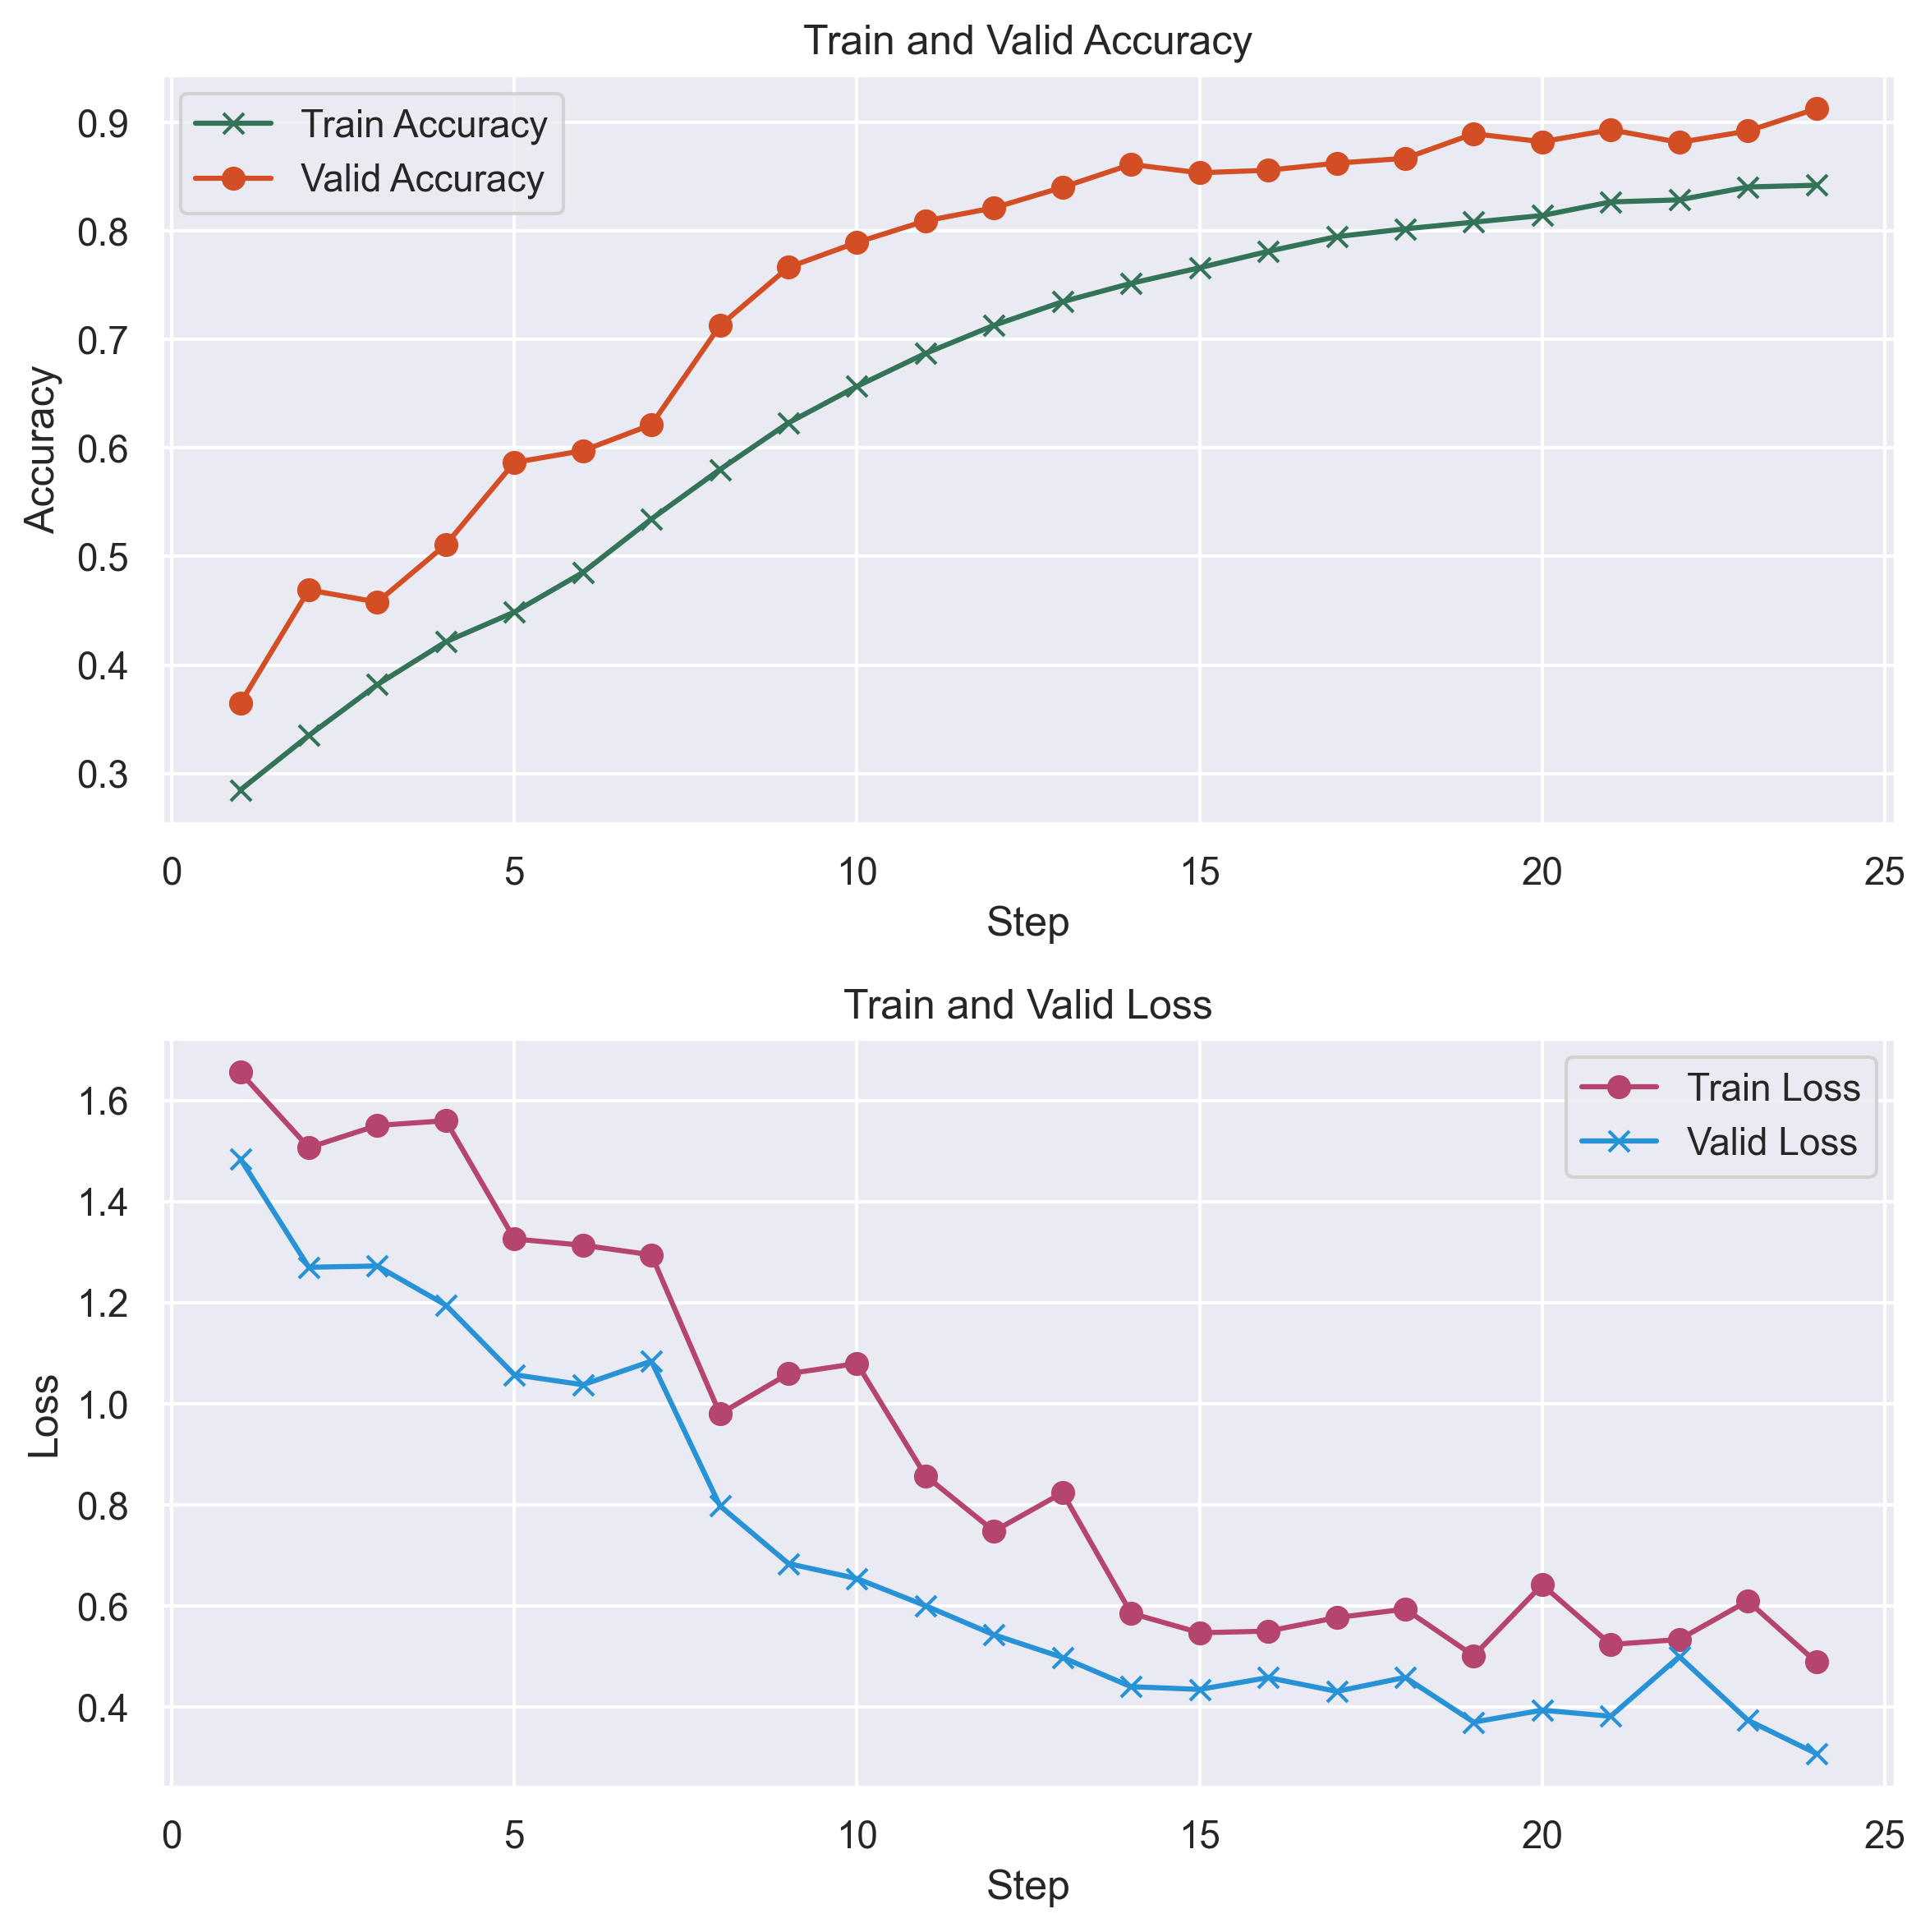

In [11]:
plot_metrics(baseline_metrics, colors=['#337357', '#D34E24', '#B5446E', '#2892D7'])

## Conclusion

- Even without Transfer Learning models are good (`91%`), but demanding.
- Wide Residual Networks boost accuracy up to `94%`, (`99%` in some scientific papers), save computation time and memory.
- Land covers of similar tone or shape (Lakes and Forests)  are hard to differentiate. 